### **Análisis Exploratorio de los Datos**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'monospace'
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [2]:
# Navegar hasta la raíz del proyecto 
WORKSPACE = os.path.abspath(os.path.join(os.getcwd()))

# Definir la ruta de la carpeta de datos
DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')

print("Workspace:", WORKSPACE)
print("Data folder:", DATA_FOLDER)

Workspace: /tf
Data folder: /tf/productos/test/precipitation-forecast-co/data


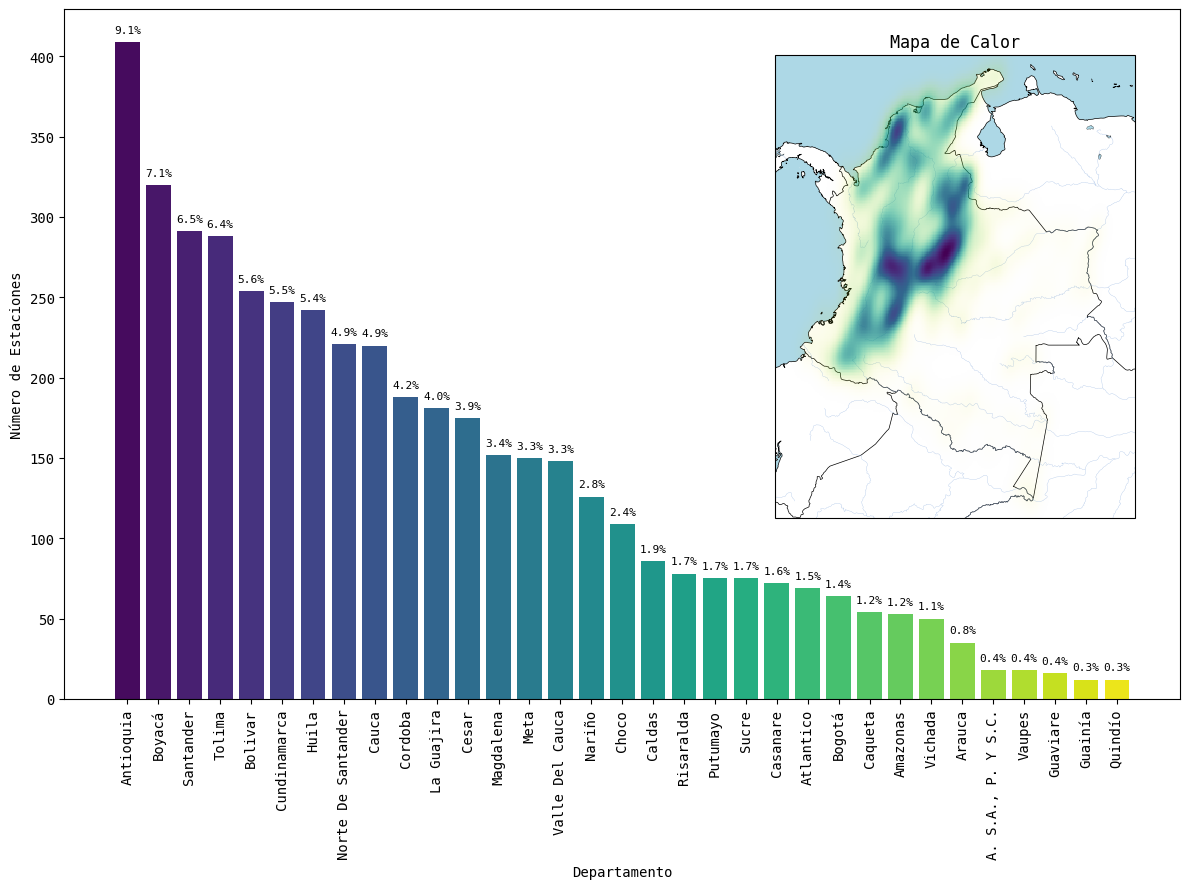

In [5]:
# Leer el archivo Excel del catalogo nacional de estaciones
cne_df = pd.read_excel(os.path.join(DATA_FOLDER, 'CNE_IDEAM.xls'), sheet_name='CNE')

# Agrupar por departamento
department_counts = cne_df['DEPARTAMENTO'].value_counts().sort_values(ascending=False)
total_stations = department_counts.sum()
department_percentages = (department_counts / total_stations * 100).round(1)

# Crear DataFrame para graficar
plot_df = pd.DataFrame({
    'DEPARTAMENTO': department_counts.index,
    'Estaciones': department_counts.values,
    'Porcentaje': department_percentages.values
})

# Reemplazar nombre de departamento
plot_df['DEPARTAMENTO'] = plot_df['DEPARTAMENTO'].replace({
    'Archipielago De San Andres, Providencia Y Santa Catalina': 'A. S.A., P. Y S.C.'
})

# Colores pastel
colors =  sns.color_palette('viridis', len(plot_df))

fig, ax = plt.subplots(figsize=(12, 9))
bars = ax.bar(plot_df['DEPARTAMENTO'], plot_df['Estaciones'], color=colors, width=0.8) 

# Mostrar porcentaje encima de cada barra
for i, (value, pct) in enumerate(zip(plot_df['Estaciones'], plot_df['Porcentaje'])):
    ax.text(i, value + total_stations*0.001, f'{pct}%', ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Departamento')
ax.set_ylabel('Número de Estaciones')
plt.xticks(rotation=90)
plt.tight_layout()

# Crear un subplot con proyección geográfica de Cartopy
rect_ax = fig.add_axes([0.65, 0.4, 0.3, 0.55], projection=ccrs.PlateCarree())
rect_ax.set_xticks([])
rect_ax.set_yticks([])

# Agregar límites y costas de Colombia
rect_ax.set_extent([-80, -66, -5, 13], crs=ccrs.PlateCarree())
rect_ax.add_feature(cfeature.BORDERS, linewidth=0.5)
rect_ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
rect_ax.add_feature(cfeature.LAND, facecolor='white')
rect_ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
rect_ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='k', linewidth=0.2)
rect_ax.add_feature(cfeature.RIVERS, linewidth=0.2)

# Mapa de calor de deslizamientos
x = cne_df['LONGITUD'].values
y = cne_df['LATITUD'].values

# Calcular el KDE solo para puntos dentro de Colombia
mask = (x > -80) & (x < -66) & (y > -5) & (y < 13)
x = x[mask]
y = y[mask]

if len(x) > 0:
    # Crear grilla
    xi, yi = np.mgrid[-80:-66:300j, -5:13:300j]
    coords = np.vstack([x, y])
    kde = gaussian_kde(coords, bw_method=0.15)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
    zi_reshaped = zi.reshape(xi.shape)
    # Normalizar zi para usar como alpha (0 = transparente, 1 = opaco)
    alpha_mask = (zi_reshaped - zi_reshaped.min()) / (zi_reshaped.max() - zi_reshaped.min())
    # Opcional: hacer más transparente los valores bajos
    alpha_mask = np.clip(alpha_mask * 1.5, 0, 1)
    # Graficar el mapa de calor con alpha variable
    pcm = rect_ax.pcolormesh(
        xi, yi, zi_reshaped, cmap='viridis_r', shading='auto', zorder=2,
        transform=ccrs.PlateCarree()
    )
    pcm.set_alpha(alpha_mask)

rect_ax.set_title('Mapa de Calor')

#plt.show()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/distribucion_estaciones.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

In [49]:
# Read the CSV file
df = pd.read_csv(
    os.path.join(DATA_FOLDER, 'raw', 'PTPM_CON.csv'),
    usecols=['Fecha', 'CodigoEstacion', 'Valor'],
    dtype={'Fecha': str, 'CodigoEstacion': str, 'Valor': str},
)
# Convert 'Valor' to numeric
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
# Convert 'Fecha' to datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
# Drop rows with NaN values in 'Valor' or 'Fecha'
df = df.dropna(subset=['Valor', 'Fecha'])
# Normalize the 'Fecha' column to remove the time component
df['Fecha'] = df['Fecha'].dt.normalize()

In [50]:
num_stations = df['CodigoEstacion'].nunique()
print("Number of unique stations:", num_stations)
print("Total number of data points:", len(df))

Number of unique stations: 2036
Total number of data points: 14762874


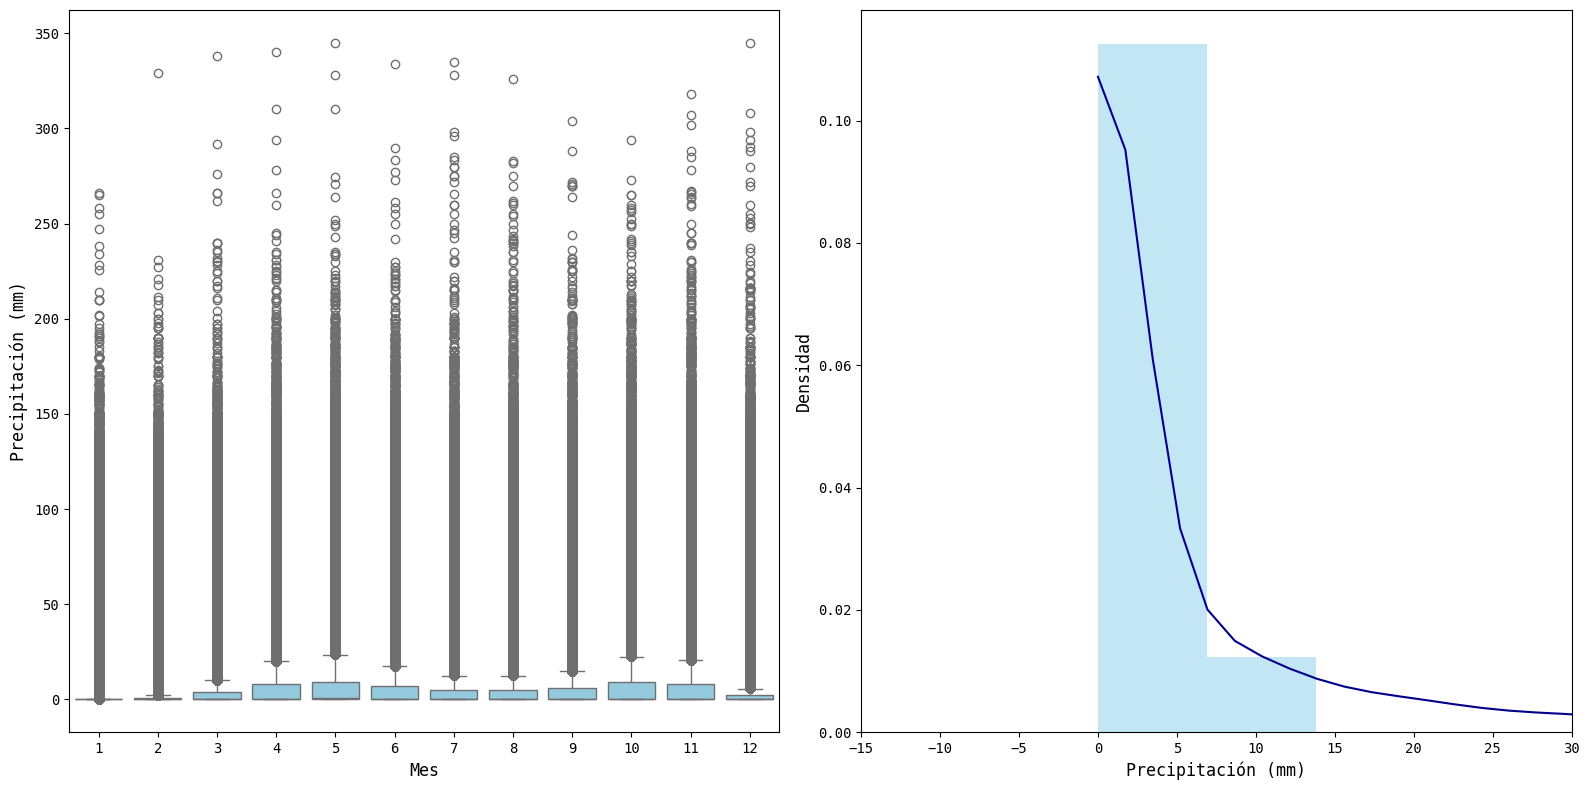

In [73]:
# Crear la figura y los ejes
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})

# Crear el boxplot clasificado por mes en el primer eje
df['Mes'] = df['Fecha'].dt.month
sns.boxplot(x='Mes', y='Valor', data=df, color='skyblue', ax=axes[0])
axes[0].set_xlabel('Mes', fontsize=12)
axes[0].set_ylabel('Precipitación (mm)', fontsize=12)

# Crear la distribución de frecuencia considerando la densidad en el segundo eje
sns.histplot(
    df['Valor'], bins=50, kde=True, stat='density', color='skyblue', 
    ax=axes[1], kde_kws={'bw_adjust': 5}, edgecolor=None
)
axes[1].set_xlabel('Precipitación (mm)', fontsize=12)
axes[1].set_ylabel('Densidad', fontsize=12)

# Ajustar el rango del eje x para que comience en -10
axes[1].set_xlim(-15, 30)

# Cambiar el color del kde a azul oscuro
for line in axes[1].lines:
    line.set_color('darkblue')

# Eliminar todas las barras del histograma excepto las dos primeras
for i, patch in enumerate(axes[1].patches):
    if i >= 2:
        patch.set_visible(False)

# Ajustar el diseño
plt.tight_layout()

#plt.show()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/boxplot_densidad.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

In [60]:
# Create a matrix of data presence
unique_stations = df['CodigoEstacion'].unique()
unique_dates = pd.date_range(start='2000-01-01', end='2024-12-31')

# Create a dictionary to map stations and dates to indices
station_to_idx = {station: idx for idx, station in enumerate(unique_stations)}
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create an empty matrix
presence_matrix = np.zeros((len(unique_stations), len(unique_dates)), dtype=int)

# Fill the matrix with 1 if data exists
for _, row in df.iterrows():
    station_idx = station_to_idx[row['CodigoEstacion']]
    date_idx = date_to_idx[row['Fecha']]
    presence_matrix[station_idx, date_idx] = 1

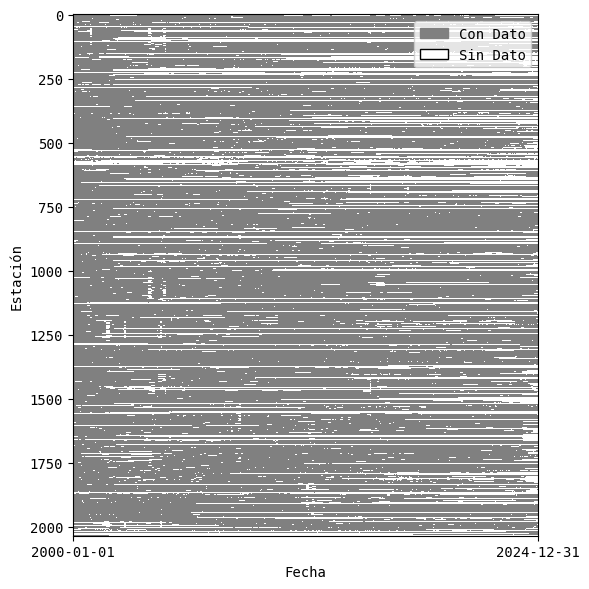

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Display the matrix as an image
ax.imshow(
    presence_matrix,
    aspect='auto',
    cmap=ListedColormap(['white', 'gray']),
    interpolation='none'
)

# Configure the axes
ax.set_xlabel('Fecha')
ax.set_ylabel('Estación')
ax.set_xticks([0, len(unique_dates) - 1])
ax.set_xticklabels(['2000-01-01', '2024-12-31'])

# Add legend
legend_elements = [
    Patch(facecolor='gray', edgecolor='gray', label='Con Dato'),
    Patch(facecolor='white', edgecolor='black', label='Sin Dato')
]
ax.legend(handles=legend_elements, loc='upper right')

# Adjust the layout
plt.tight_layout()

#plt.show()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/ausencia_presencia.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

In [11]:
# Calcular el porcentaje total de datos faltantes
total_data_points = presence_matrix.size
missing_data_points = total_data_points - presence_matrix.sum()
total_missing_percentage = (missing_data_points / total_data_points) * 100

# Calcular el porcentaje promedio de datos faltantes por estación
missing_percentage_per_station = (1 - presence_matrix.sum(axis=1) / presence_matrix.shape[1]) * 100

print(f"Porcentaje de datos faltantes: {total_missing_percentage:.2f}%")
num_stations_high_missing = np.sum(missing_percentage_per_station > 80)
# Obtener los códigos de las estaciones con más del 80% de datos faltantes
stations_high_missing = unique_stations[missing_percentage_per_station > 80]

# Guardar los códigos de las estaciones en un archivo CSV
missing_stations_df = pd.DataFrame({'CodigoEstacion': stations_high_missing})
missing_stations_df.to_csv(os.path.join(DATA_FOLDER, 'stations_high_missing.csv'), index=False)

print(f"Número de estaciones con más del 80% de datos faltantes: {num_stations_high_missing}")
print("Archivo 'stations_high_missing.csv' guardado con éxito.")

Porcentaje de datos faltantes: 20.60%
Número de estaciones con más del 80% de datos faltantes: 225
Archivo 'stations_high_missing.csv' guardado con éxito.


In [17]:
# Calcular el porcentaje de persistencia de Valor menor o igual a 1 por estación
zero_persistence_percentage = df[df['Valor'] <= 1].groupby('CodigoEstacion').size().reindex(unique_stations) / presence_matrix.sum(axis=1) * 100

# Contar el número de estaciones con persistencia de Valor menor o igual a 1 en más del 80% de los datos
num_stations_high_zero_persistence = np.sum(zero_persistence_percentage > 80)

print(f"Número de estaciones con persistencia de precipitación <= 1 en más del 80% de los datos: {num_stations_high_zero_persistence}")

# Guardar los códigos de las estaciones con alta persistencia en un archivo CSV
high_zero_persistence_stations = unique_stations[zero_persistence_percentage > 80]
high_zero_persistence_stations_df = pd.DataFrame({'CodigoEstacion': high_zero_persistence_stations})
high_zero_persistence_stations_df.to_csv(os.path.join(DATA_FOLDER, 'stations_zero_persistence.csv'), index=False)
print("Archivo 'stations_zero_persistence.csv' guardado con éxito.")

Número de estaciones con persistencia de precipitación <= 1 en más del 80% de los datos: 273
Archivo 'stations_zero_persistence.csv' guardado con éxito.


In [18]:
# Calcular el porcentaje de persistencia de Valor mayor o igual a 1 por estación
rain_persistence_percentage = df[df['Valor'] >= 1].groupby('CodigoEstacion').size().reindex(unique_stations) / presence_matrix.sum(axis=1) * 100

# Contar el número de estaciones con persistencia de Valor menor o igual a 1 en más del 95% de los datos
num_stations_high_rain_persistence = np.sum(rain_persistence_percentage > 95)

print(f"Número de estaciones con persistencia de precipitación >= 1 en más del 95% de los datos: {num_stations_high_rain_persistence}")
# Guardar los códigos de las estaciones con alta persistencia en un archivo CSV
high_rain_persistence_stations = unique_stations[rain_persistence_percentage > 95]
high_rain_persistence_stations_df = pd.DataFrame({'CodigoEstacion': high_rain_persistence_stations})
high_rain_persistence_stations_df.to_csv(os.path.join(DATA_FOLDER, 'stations_rain_persistence.csv'), index=False)
print("Archivo 'stations_rain_persistence.csv' guardado con éxito.")

Número de estaciones con persistencia de precipitación >= 1 en más del 95% de los datos: 4
Archivo 'stations_rain_persistence.csv' guardado con éxito.


In [19]:
# Calcular el coeficiente de variación (CV) por estación
cv_per_station = df.groupby('CodigoEstacion')['Valor'].agg(lambda x: x.std() / x.mean())

# Contar el número de estaciones con CV menor al umbral
num_stations_low_variability = np.sum(cv_per_station < 0.1)

print(f"Número de estaciones con un índice de variabilidad muy bajo: {num_stations_low_variability}")

Número de estaciones con un índice de variabilidad muy bajo: 0


In [76]:
# Read the CSV file
df = pd.read_csv(
    os.path.join(DATA_FOLDER, 'raw', 'PTPM_CON.csv'),
    usecols=['Fecha', 'CodigoEstacion', 'Valor'],
    dtype={'Fecha': str, 'CodigoEstacion': str, 'Valor': str},
)
# Convert 'Valor' to numeric
df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
# Convert 'Fecha' to datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
# Drop rows with NaN values in 'Valor' or 'Fecha'
df = df.dropna(subset=['Valor', 'Fecha'])
# Normalize the 'Fecha' column to remove the time component
df['Fecha'] = df['Fecha'].dt.normalize()

# Read the station files and extract 'CodigoEstacion' columns as strings
high_missing_stations = pd.read_csv(os.path.join(DATA_FOLDER, 'stations_high_missing.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
rain_persistence_stations = pd.read_csv(os.path.join(DATA_FOLDER, 'stations_rain_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
zero_persistence_stations = pd.read_csv(os.path.join(DATA_FOLDER, 'stations_zero_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']

# Combine all stations to exclude
stations_to_exclude = pd.concat([high_missing_stations, rain_persistence_stations, zero_persistence_stations]).unique()

# Filter out rows with 'CodigoEstacion' in the exclusion list
df = df[~df['CodigoEstacion'].isin(stations_to_exclude)]


num_stations = df['CodigoEstacion'].nunique()
print("Number of unique stations:", num_stations)
print("Total number of data points:", len(df))

Number of unique stations: 1592
Total number of data points: 12812512


In [77]:
# Normalizar 'Valor' entre 0 y 1 agrupado por 'CodigoEstacion'
df['Valor_Normalizado'] = df.groupby('CodigoEstacion')['Valor'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

def split_series(series, window_size=7):
    shape = (series.size - window_size + 1, window_size)
    strides = series.strides * 2
    return np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)

all_windows = []
unique_stations = df['CodigoEstacion'].unique()

for station in unique_stations:
    series = df[df['CodigoEstacion'] == station]['Valor_Normalizado'].values
    windows = split_series(series, window_size=7)
    all_windows.append(windows)

In [ ]:
def process_station(station_idx):
    # Esta función procesa una estación completa
    all_matches = []
    
    # Para cada fila en la estación
    for i in range(len(all_windows[station_idx])):
        # Calcular los diferencias para la fila i de esta estación
        diffs = [abs(windows - all_windows[station_idx][i]) for windows in all_windows]
        # Aplicar la condición a cada fila
        matches = [
            np.any(np.all(row < 0.05, axis=1))
            for row in diffs
        ]
        all_matches.append(np.array(matches))
    
    # Convertir a numpy array
    all_matches = np.array(all_matches)
    # Calcular resultados para esta estación
    results = np.sum(all_matches, axis=0) / len(all_windows[station_idx])

    # Save the results as a single-row CSV file with columns as unique_stations
    output_csv_path = os.path.join(DATA_FOLDER, f'correlation/{unique_stations[station_idx]}.csv')
    pd.DataFrame([np.round(results, 2)], columns=unique_stations).to_csv(output_csv_path, index=False)
    print(f"Processed station {station_idx}: {unique_stations[station_idx]}")
    return results

# Crear la carpeta si no existe
correlation_folder = os.path.join(DATA_FOLDER, 'correlation')
os.makedirs(correlation_folder, exist_ok=True)
# Leer los nombres de los archivos CSV en la carpeta correlation
csv_files = [os.path.splitext(file)[0] for file in os.listdir(correlation_folder) if file.endswith('.csv')]
# Identificar los station_idx que no han sido procesados
unprocessed_station_idx = [i for i in range(num_stations) if unique_stations[i] not in csv_files]
# Dividir los índices de las estaciones en batches del tamaño de cpu_counts*0.6
batch_size = int(os.cpu_count() * 0.6)
# Crear batches de estaciones no procesadas
station_batches = [unprocessed_station_idx[i:i + batch_size] for i in range(0, len(unprocessed_station_idx), batch_size)]

# Iterar sobre cada batch de estaciones
for batch in station_batches:
    # Crear un ejecutor de procesos para paralelizar el cálculo
    with ProcessPoolExecutor(max_workers=len(batch)) as executor:
        # Ejecutar el proceso en paralelo para cada estación en el batch
        all_station_results = list(executor.map(process_station, batch))

Processed station 1412: 46015030
Processed station 1429: 47015090
Processed station 1408: 44187010
Processed station 1427: 47015070
Processed station 1440: 47040050
Processed station 1406: 44167010
Processed station 1407: 44167020
Processed station 1445: 47075010
Processed station 1431: 47017170
Processed station 1437: 47035020
Processed station 1435: 47030020
Processed station 1444: 47067020
Processed station 1441: 47045010
Processed station 1415: 46040010
Processed station 1432: 47020010
Processed station 1425: 47010230
Processed station 1409: 44187020
Processed station 1436: 47030030
Processed station 1433: 47020020
Processed station 1439: 47040040
Processed station 1411: 46015020
Processed station 1438: 47040020
Processed station 1442: 47047020
Processed station 1410: 44187030
Processed station 1421: 47010110
Processed station 1434: 47030010
Processed station 1424: 47010220
Processed station 1416: 47010020
Processed station 1413: 46035010
Processed station 1443: 47060010
Processed 

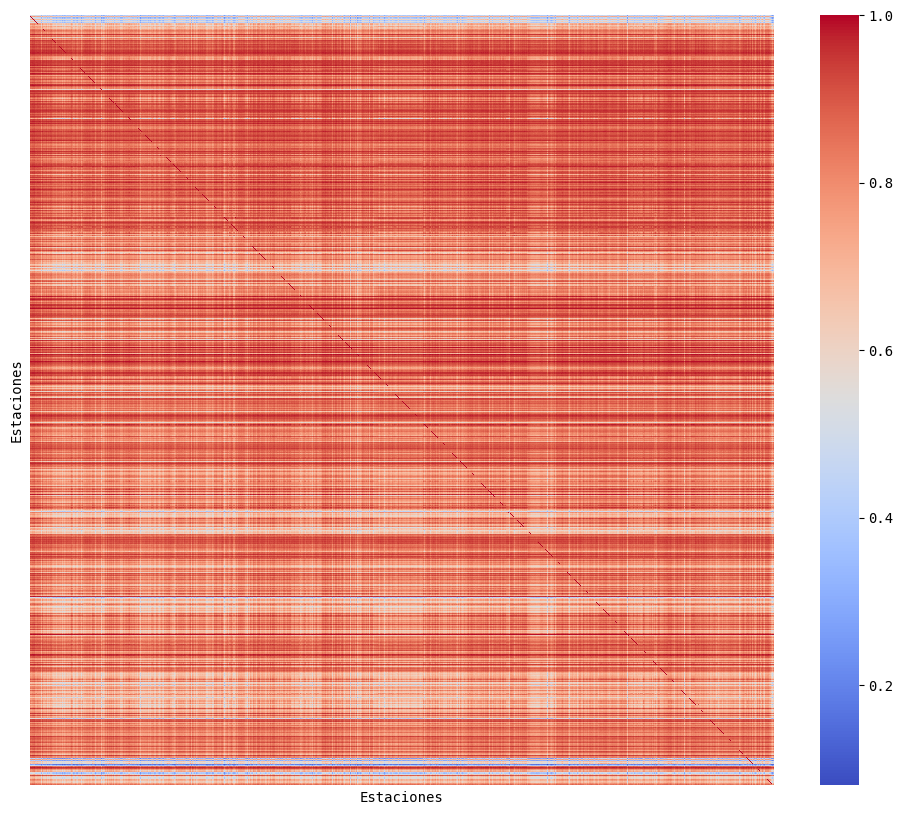

In [ ]:
# Leer los nombres de los archivos CSV en la carpeta correlation
correlation_folder = os.path.join(DATA_FOLDER, 'correlation')
csv_files = [os.path.splitext(file)[0] for file in os.listdir(correlation_folder) if file.endswith('.csv')]

# Leer todos los CSV de la carpeta correlation y combinarlos en un DataFrame
correlation_data = []
for file in csv_files:
    file_path = os.path.join(correlation_folder, f"{file}.csv")
    df_csv = pd.read_csv(file_path)
    df_csv.index = [file]  # Usar el nombre del archivo como índice
    correlation_data.append(df_csv)

# Combinar todos los DataFrames en uno solo
combined_df = pd.concat(correlation_data, axis=0)

# Asegurarse de que el índice y las columnas estén en el mismo orden
correlation_matrix = combined_df.loc[unique_stations, unique_stations]

# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False)
plt.xlabel('Estaciones')
plt.ylabel('Estaciones')
#plt.show()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/matriz_correlacion.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")